# Qiskit Hands-on Session. Part 2: Fly free little birds

**Sim-MBQP 2025**

**Elena Peña Tapia, IBM Quantum**

In [20]:
# uncomment to install packages

# ! pip install qiskit==1.4.3, qiskit-nature
# ! pip install graphviz
# ! pip install qiskit-ibm-runtime
# ! pip install ffsim
# ! pip install matplotlib
# ! pip install pylatexenc

In this session, we will see how transpilation can help compute the magnetization of a state defined by an 18-qubit Fermi-Hubbard model.

The notebook contains sections where you can play around with transpilation settings to try to optimize your circuit depth and 2q-gate count before running.

Note: Running on hardware is optional, the full exercise can be performed with a local "fake" backend too.

In [2]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke, FakeAlmadenV2

backend = FakeSherbrooke()
backend = FakeAlmadenV2()
print("Num.qubits", backend.num_qubits)

Num.qubits 20


In [3]:
# UNCOMMENT TO RUN ON REAL HW
# from qiskit_ibm_runtime import QiskitRuntimeService

# service = QiskitRuntimeService(channel="ibm_cloud")
# backend = service.backend("ibm_sherbrooke")

The structure of the notebook will again follow the Qiskit Pattern:

<img src="images/qiskit_pattern.png" alt="Drawing" style="width: 1000px;"/>

## Step 1: Map problem to a quantum circuit

The first step is to build the Fermionic Hamiltonian that we wish to simulate, and convert it to a "qubit" Hamiltonian. Qiskit doesn't contain specific mapping tools for this task, but there are different open-source libraries in `qiskit-community` that target the mapping step for different domains.

**Using `ffsim`**

[`ffsim`](https://github.com/qiskit-community/ffsim) is a software library for simulating fermionic quantum circuits that conserve particle number and the Z component of spin. This category includes many quantum circuits used for quantum chemistry simulations.

In [4]:
def map_with_ffsim():
    import ffsim

    norb_x, norb_y = 3, 3  # 3x3 square lattice
    t = 1.0                # tunneling
    U = -0.5               # onsite_interaction

    fermionic_hamiltonian = ffsim.operators.fermi_hubbard_2d(
        norb_x=norb_x,
        norb_y=norb_y,
        tunneling=t,
        interaction=U,
        periodic=False
    )
    print(f"Fermionic Hamiltonian:\n {fermionic_hamiltonian}\n")

    qubit_hamiltonian = ffsim.qiskit.jordan_wigner(
        op=fermionic_hamiltonian,
    )
    print(f"Qubit Hamiltonian:\n {qubit_hamiltonian}\n")
    print(f'{qubit_hamiltonian.num_qubits} qubits, {len(qubit_hamiltonian)} Pauli terms')
    return qubit_hamiltonian

**Using `qiskit-nature`**

This package contains a larger array of mappers, including the `BravyiKitaevMapper()` and `BravyiKitaevSuperfastMapper()`. Unfortunately, it is no longer maintained by IBM, which means there are no guarantees of compatibility with new versions of qiskit. Currently, `qiskit-nature` is capped to `qiskit<2.0`. 

In [5]:
def map_with_nature():
    from qiskit_nature.second_q import hamiltonians, mappers

    U = -0.5  # onsite_interaction
    lattice = hamiltonians.lattices.SquareLattice(rows=3, cols=3)

    model = hamiltonians.FermiHubbardModel(lattice, onsite_interaction=U)
    fermionic_hamiltonian = model.second_q_op().simplify()

    print(f"Fermionic Hamiltonian:\n {fermionic_hamiltonian}\n")

    qubit_hamiltonian = mappers.BravyiKitaevMapper().map(
        fermionic_hamiltonian
    )
    print(f"Qubit Hamiltonian:\n {qubit_hamiltonian}\n")
    print(f'{qubit_hamiltonian.num_qubits} qubits, {len(qubit_hamiltonian)} Pauli terms')
    return qubit_hamiltonian

In [6]:
# qubit_hamiltonian = map_with_nature()
qubit_hamiltonian = map_with_ffsim()

Fermionic Hamiltonian:
 FermionOperator({
    (cre_a(0), des_a(1)): -1,
    (cre_b(3), des_b(4)): -1,
    (cre_a(7), des_a(4)): -1,
    (cre_b(4), des_b(5)): -1,
    (cre_b(4), des_b(7)): -1,
    (cre_b(6), des_b(7)): -1,
    (cre_a(6), des_a(6), cre_b(6), des_b(6)): -0.5,
    (cre_a(1), des_a(4)): -1,
    (cre_a(2), des_a(1)): -1,
    (cre_a(6), des_a(3)): -1,
    (cre_a(4), des_a(5)): -1,
    (cre_a(7), des_a(6)): -1,
    (cre_b(8), des_b(5)): -1,
    (cre_b(4), des_b(1)): -1,
    (cre_b(3), des_b(0)): -1,
    (cre_b(0), des_b(3)): -1,
    (cre_b(4), des_b(3)): -1,
    (cre_a(4), des_a(7)): -1,
    (cre_a(8), des_a(7)): -1,
    (cre_b(1), des_b(2)): -1,
    (cre_a(1), des_a(2)): -1,
    (cre_a(5), des_a(2)): -1,
    (cre_a(5), des_a(4)): -1,
    (cre_a(7), des_a(8)): -1,
    (cre_b(7), des_b(8)): -1,
    (cre_a(8), des_a(5)): -1,
    (cre_a(5), des_a(8)): -1,
    (cre_a(3), des_a(6)): -1,
    (cre_b(1), des_b(0)): -1,
    (cre_b(7), des_b(4)): -1,
    (cre_b(5), des_b(8)): -1,
    (c

Once we have a qubit Hamiltonian formatted as a `SparsePauliOp` class, we can plug it into a quantum circuit using the `PauliEvolutionGate`:

In [7]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import QuantumCircuit

circuit = QuantumCircuit(qubit_hamiltonian.num_qubits)
circuit = circuit.compose(PauliEvolutionGate(qubit_hamiltonian))
print(circuit.count_ops())
print(circuit.depth())

OrderedDict([('PauliEvolution', 1)])
1


The starting circuit is a "black box", so we decompose it to get an initial estimation of the depth and size:

In [8]:
decomposed = circuit.decompose()
decomposed.draw('mpl', fold=-1)

print("num-qubits:", decomposed.num_qubits)
print("num-ops:", decomposed.count_ops())
print("total-depth:",decomposed.depth())
print(f'2q-size: {decomposed.size(lambda x: x.operation.num_qubits==2)}')
print(f'2q-depth: {decomposed.depth(lambda x: x.operation.num_qubits==2)}')

num-qubits: 18
num-ops: OrderedDict([('cx', 144), ('h', 48), ('rz', 42), ('sx', 24), ('sxdg', 24), ('ryy', 12), ('rxx', 12), ('rzz', 9)])
total-depth: 121
2q-size: 177
2q-depth: 80


We use the information from the circuit to build our magnetization observable:

To get observable for magnetization:

   - For each spin-up qubit qiqi​, measure ⟨Zi⟩⟨Zi​⟩

   - For spin-down qjqj​, measure ⟨Zj⟩⟨Zj​⟩

In [9]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

num_qubits = circuit.num_qubits
spin_up_indices = list(range(0, num_qubits, 2))
spin_down_indices = list(range(1, num_qubits, 2))
coeffs = []
paulis = []

for i in spin_down_indices:
    z_string = ['I'] * num_qubits
    z_string[i] = 'Z'
    paulis.append(''.join(z_string))
    coeffs.append(+1)

for i in spin_up_indices:
    z_string = ['I'] * num_qubits
    z_string[i] = 'Z'
    paulis.append(''.join(z_string))
    coeffs.append(-1)

m_op = SparsePauliOp(paulis, np.array(coeffs) * 0.5)
print("Observable: ", m_op)

Observable:  SparsePauliOp(['IZIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIII', 'IIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIII', 'IIIIIIIIZIIIIIIIII', 'IIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIZI'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j])


## Step 2. Optimize for Hardware (transpile)

We have our starting circuit and initial metrics, so we can try to apply different strategies to improve the circuit depth, and especially, the 2q depth. We can try using the preset pass manager:

### Qiskit pass manager with opt. level 1

In [10]:
passes = []
kwargss = []
def callback_func(**kwargs):
    t_pass = kwargs['pass_'].name()
    kwargss.append(kwargs)
    passes.append(t_pass)

qubits: 20
2q-size: 277
2q-depth: 143


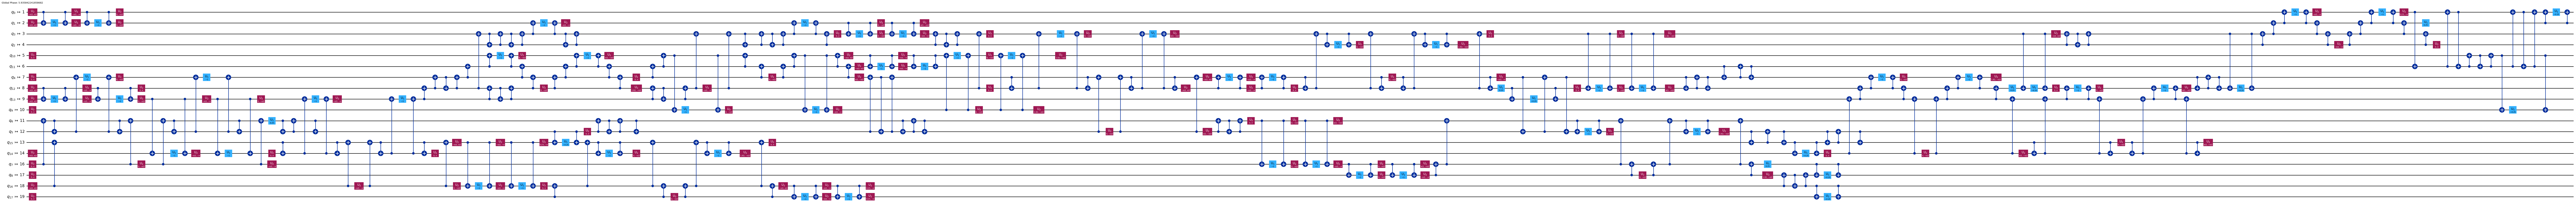

In [11]:
from qiskit import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
circuit_synth = pm.run(circuit, callback=callback_func)

print(f'qubits: {circuit_synth.num_qubits}')
print(f'2q-size: {circuit_synth.size(lambda x: x.operation.num_qubits==2)}')
print(f'2q-depth: {circuit_synth.depth(lambda x: x.operation.num_qubits==2)}')
circuit_synth.draw('mpl', fold=-1)

qubits: 20
2q-size: 289
2q-depth: 137


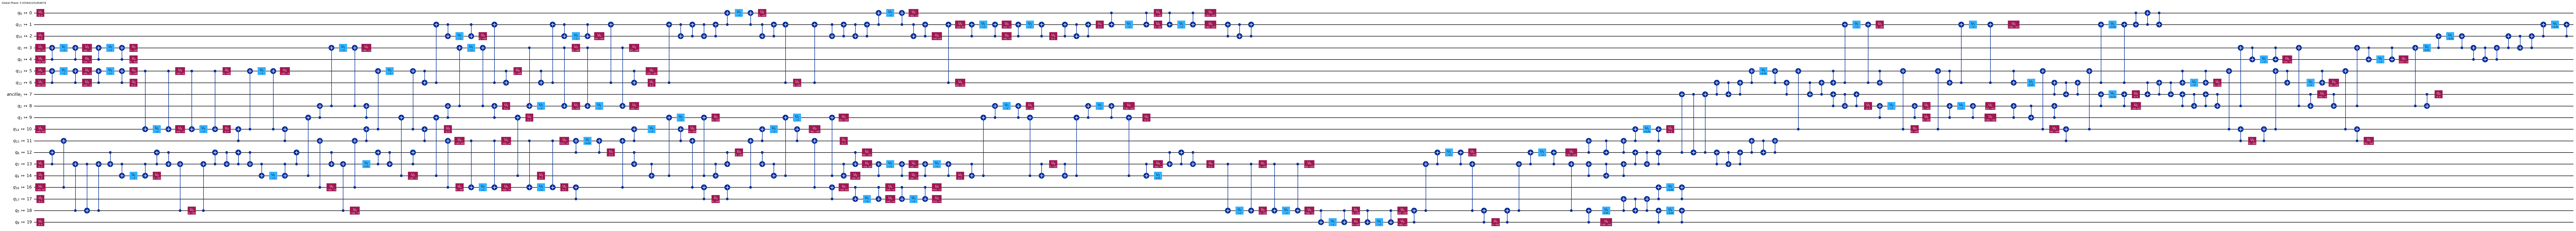

In [12]:
# HERE: try improving the result using the preset pass manager settings 
# pm = 
circuit_synth = pm.run(circuit, callback=callback_func)

print(f'qubits: {circuit_synth.num_qubits}')
print(f'2q-size: {circuit_synth.size(lambda x: x.operation.num_qubits==2)}')
print(f'2q-depth: {circuit_synth.depth(lambda x: x.operation.num_qubits==2)}')
circuit_synth.draw('mpl', fold=-1)

### 2-Qubit Unitary Approximation

You can ask Qiskit to approximate your circuit by replacing 2-qubit subcircuits by fewer gates if it meets some closeness criteria. This is worth it if your 2-qubit gates are somewhat noisy. 

`approximation_degree=None`  will consult the Target for error rates and tailor approximation to the error rate of each 2-qubit gate.


qubits: 20
2q-size: 293
2q-depth: 157


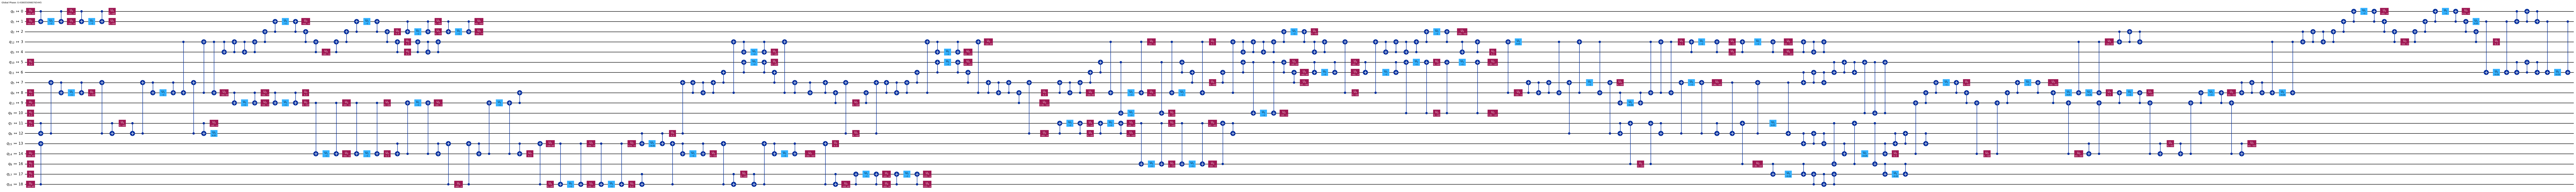

In [13]:
# HERE: Try advanced settings
# pm = generate_preset_pass_manager(optimization_level= Try setting a level,
#                                   backend=backend, 
#                                   approximation_degree= Try setting a value from 0 to 1
#                                   )
circuit_synth = pm.run(circuit, callback=callback_func)

print(f'qubits: {circuit_synth.num_qubits}')
print(f'2q-size: {circuit_synth.size(lambda x: x.operation.num_qubits==2)}')
print(f'2q-depth: {circuit_synth.depth(lambda x: x.operation.num_qubits==2)}')
circuit_synth.draw('mpl', fold=-1)

### Synthesis using Plugins

In [14]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig

hls_config = HLSConfig(PauliEvolution=
    [
        ("default", {"preserve_order": False})
    ]
)

hls_config = HLSConfig(PauliEvolution=
    [
        ("rustiq", 
        {"upto_clifford": True, "preserve_order": True, "optimize_count": False})
    ]
)

qubits: 20
2q-size: 306
2q-depth: 127


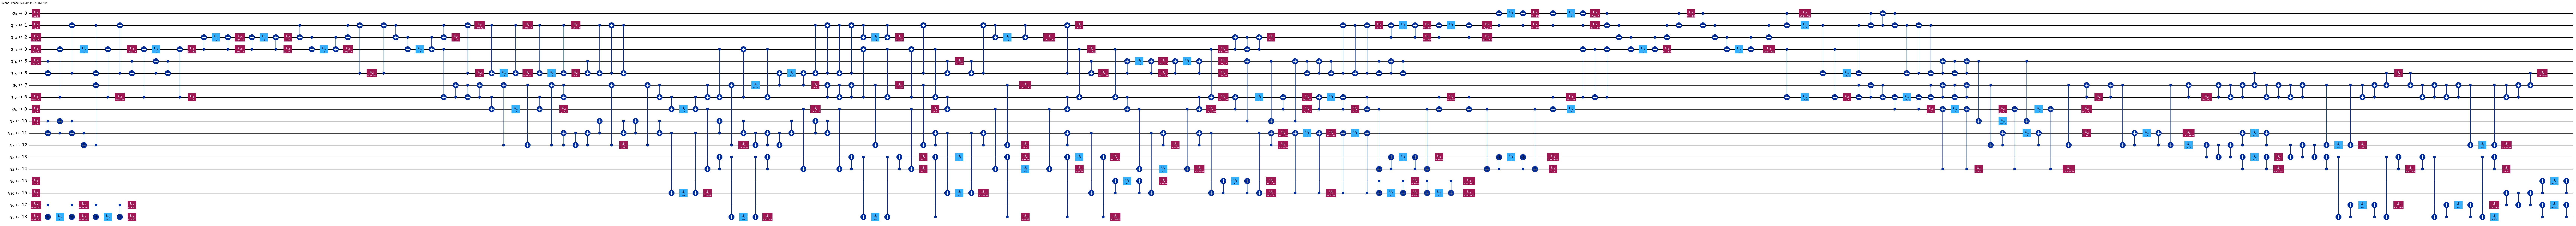

In [15]:
# HERE: Define a pass manager using a HLS plugin, you can follow the references above (and maybe optimize the settings!)
# pm = 
circuit_synth = pm.run(circuit)

print(f'qubits: {circuit_synth.num_qubits}')
print(f'2q-size: {circuit_synth.size(lambda x: x.operation.num_qubits==2)}')
print(f'2q-depth: {circuit_synth.depth(lambda x: x.operation.num_qubits==2)}')
circuit_synth.draw('mpl', fold=-1)

## Step 3. Execute on Hardware

In [16]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(mode=backend)

print("Running on backend", estimator.backend())

isa_circuit = circuit_synth
isa_operator = m_op.apply_layout(circuit_synth.layout)

pub = [(isa_circuit, isa_operator)]
result = estimator.run(pub).result()

Running on backend <qiskit_ibm_runtime.fake_provider.backends.almaden.fake_almaden.FakeAlmadenV2 object at 0x1236bbad0>


In [17]:
output_magnetization = result[0].data.evs
print(output_magnetization)

0.0


## Step 4. Compare with baseline (exact simulation)

In [18]:
from qiskit.quantum_info import Statevector

statevector = Statevector(circuit)

# compute expectation value
exact_magnetization = statevector.expectation_value(m_op)
print(f"Magnetization baseline value = {exact_magnetization.real}")

Magnetization baseline value = -5.551115123125783e-16


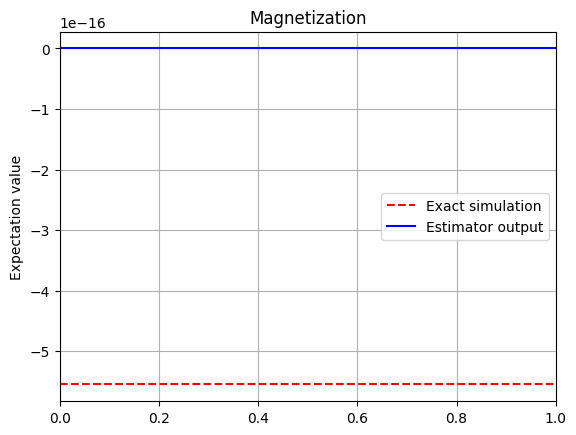

In [19]:
import matplotlib.pyplot as plt

# Add horizontal line at y=5
plt.axhline(y=exact_magnetization.real, color='r', linestyle='--', label='Exact simulation')
plt.axhline(y=output_magnetization.real, color='b', label='Estimator output')

plt.ylabel('Expectation value')
plt.title('Magnetization')
plt.legend()
plt.grid(True)
plt.show()